In [1]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce

from fbprophet import Prophet

import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# plotly.tools.set_credentials_file(username='smillett', api_key='MXYpm8AMvEte7SSw6dKu')

# Import CSV Data

In [3]:
# Import dataset
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_5m_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 166.0659215450287 seconds ---


# Data cleaning

In [4]:
#replace all missing values with 0
master_df = master_df.replace(-999, 0)
master_df['time']=pd.to_datetime(master_df['time'])

In [5]:
print(master_df.shape)
master_df.head()

(129295890, 15)


,src_comp,time,fail_count,LoggedOn,dns_count,newresolved_count,dur,pkt_cnt,byte_cnt,avg_pkt_size,redteam_event,proc_total,proc_exec_total,newexecute_count,Proc_run
0,C1,2017-01-01 00:00:00,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0
1,C1,2017-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
2,C1,2017-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
3,C1,2017-01-01 00:15:00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0
4,C1,2017-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0


In [6]:
master_df[['src_comp','redteam_event']].groupby('redteam_event').count()

,src_comp
redteam_event,
0.0,129295559
1.0,163
2.0,72
3.0,42
4.0,22
5.0,9
6.0,10
7.0,2
8.0,2


In [7]:
resampled_df = master_df.groupby('time').agg({'redteam_event':'sum',
                                               'dns_count':'mean',
                                               'newresolved_count':'mean',
                                               'fail_count':'mean',
                                               'LoggedOn':'mean',
                                               'dur':'mean',
                                               'pkt_cnt':'mean',
                                               'byte_cnt':'mean',
                                               'avg_pkt_size':'mean',
                                               'proc_total':'mean',
                                               'proc_exec_total':'mean',
                                               'newexecute_count':'mean',
                                               'Proc_run':'mean'} )
resampled_df.index = pd.to_datetime(resampled_df.index)
resampled_df['redteam_event'] = resampled_df.redteam_event.map(lambda x: 1 if x > 0 else x)
redteam_events = resampled_df[resampled_df['redteam_event']>0].index

In [8]:
 #Final Dataset with normalized data across all features
# Create these dataframes for later use in plotting
normalized_df = pd.DataFrame(index=resampled_df.index)

#Dataset with which shows the  data across all features
timeseries_df = pd.DataFrame(index=resampled_df.index)
for columns in resampled_df[resampled_df.columns.difference(['redteam_event','src_comp'])]:
    m=Prophet()
    prophet_test = pd.DataFrame({'ds':resampled_df.index,'y':resampled_df[columns]})
    m.fit(prophet_test)
    future=m.make_future_dataframe(periods=0)
    forecast=m.predict(future)
    timeseries_df[columns] = forecast['yhat'].values  # Mike_T graph these two against time like in other NB.
    normalized_df[columns] = resampled_df[columns] - forecast['yhat'].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

# Look at Size, Shape and Examples of Data

In [9]:
resampled_df.describe()

,redteam_event,dns_count,newresolved_count,fail_count,LoggedOn,dur,pkt_cnt,byte_cnt,avg_pkt_size,proc_total,proc_exec_total,newexecute_count,Proc_run
count,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,1.008100e+04,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000
mean,0.032437,0.088538,0.002307,0.030498,1.783684,10.482958,264.326485,2.190854e+05,17.916000,1.870221,1.477336,0.014293,1.234889
std,0.177167,0.147040,0.010892,0.014941,0.466125,12.063219,345.479439,2.851061e+05,19.366429,1.135134,1.003311,0.081148,0.915616
min,0.000000,0.000000,0.000000,0.011232,0.500000,0.000000,0.000000,0.000000e+00,0.000000,0.604762,0.509524,0.000000,0.433333
25%,0.000000,0.013553,0.000000,0.018588,1.435055,0.000000,0.000000,0.000000e+00,0.000000,1.264053,0.973613,0.000223,0.770392
50%,0.000000,0.018812,0.000223,0.024890,1.608996,3.311938,129.302994,1.228553e+05,6.124444,1.480541,1.134570,0.001146,0.915272
75%,0.000000,0.028750,0.000894,0.040067,2.123391,19.096178,369.063536,2.942974e+05,35.148259,2.362657,1.899018,0.009630,1.610678
max,1.000000,0.932969,0.466613,0.123123,4.782177,58.717549,3625.388227,3.571822e+06,77.848371,28.102342,25.396398,2.667064,23.101601


In [10]:
print (resampled_df.shape)
resampled_df.head()

(10081, 13)


,redteam_event,dns_count,newresolved_count,fail_count,LoggedOn,dur,pkt_cnt,byte_cnt,avg_pkt_size,proc_total,proc_exec_total,newexecute_count,Proc_run
time,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.033681,0.026528,0.067362,3.529657,22.837556,520.047988,497002.288525,55.782690,4.544858,3.469747,2.667064,2.816393
2017-01-01 00:05:00,0.0,0.023250,0.016352,0.065662,2.824221,18.157895,374.563618,365614.214103,42.708237,2.544200,1.758048,0.523761,1.292795
2017-01-01 00:10:00,0.0,0.022392,0.014531,0.049309,2.681991,18.431872,387.640067,383592.880896,44.429815,2.371844,1.646737,0.439257,1.207003
2017-01-01 00:15:00,0.0,0.036756,0.016599,0.043633,2.343846,18.398387,409.925777,402614.909414,39.737081,2.127816,1.447475,0.229784,1.026559
2017-01-01 00:20:00,0.0,0.019176,0.011364,0.049006,2.390862,16.827415,410.724195,396116.731771,40.040411,2.217566,1.540009,0.300900,1.108665


# Build charts looking for outliers
### Noise is removed by only looking at samples above a certain count
### We assume a feature with zero events in a time frame is not an IOC

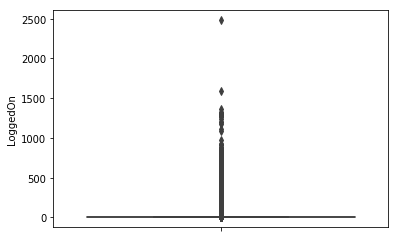

In [11]:
# First look at boxplots of sample features showing how noise prevents seeing outliers
#plt.figure()
#plt.boxplot([master_df['LoggedOn'],master_df['dns_count']]);
sns.boxplot(data=master_df, y='LoggedOn')

We removed 9.90973118% of dns_count=0 out of 10081.0 observations to see outliers


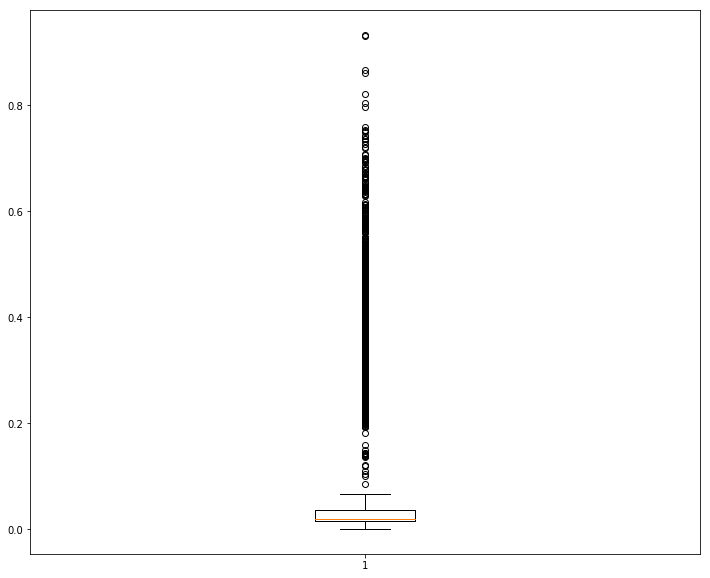

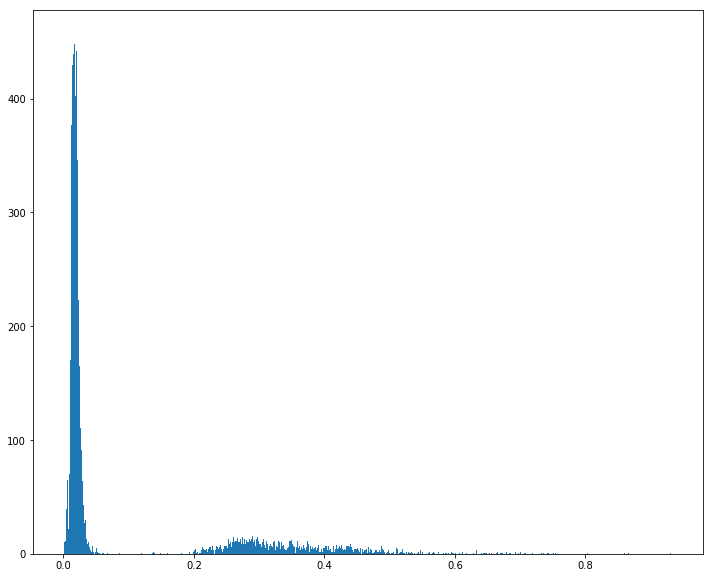

redteam_event        9082
dns_count            9082
newresolved_count    9082
fail_count           9082
LoggedOn             9082
dur                  9082
pkt_cnt              9082
byte_cnt             9082
avg_pkt_size         9082
proc_total           9082
proc_exec_total      9082
newexecute_count     9082
Proc_run             9082
dtype: int64

In [12]:
# Examine dns_count feature
dns_remove_noise = resampled_df[(resampled_df[['dns_count']] !=0).all(axis=1)]
dns_remove_pct = 1-(dns_remove_noise['dns_count'].count()/resampled_df['dns_count'].count())
print("We removed {0:2.8f}% of dns_count=0 out of {1:5.1f} observations to see outliers".format
      (dns_remove_pct*100,resampled_df['dns_count'].count()))
plt.figure(figsize=(12,10))
plt.boxplot(dns_remove_noise['dns_count'])
plt.figure(figsize=(12,10))
plt.hist(dns_remove_noise['dns_count'],bins=int(1019))
plt.show()
dns_remove_noise.count()

We removed 30.65172106% of newresolved_count=0 observations to see outliers


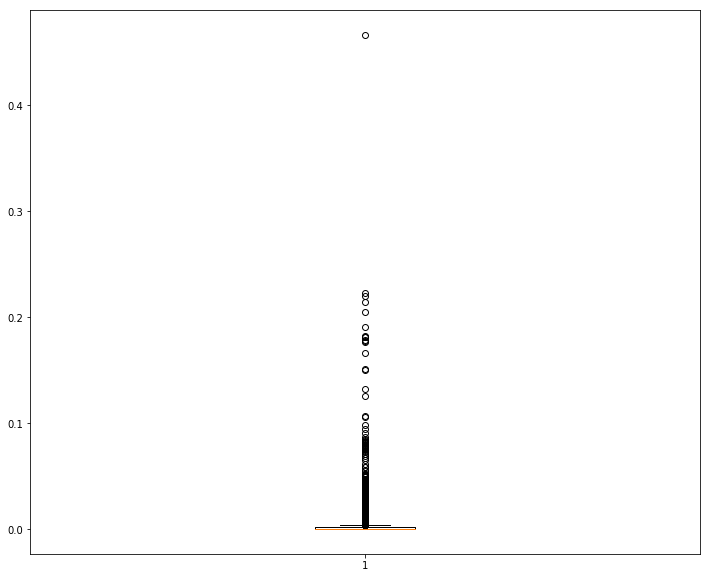

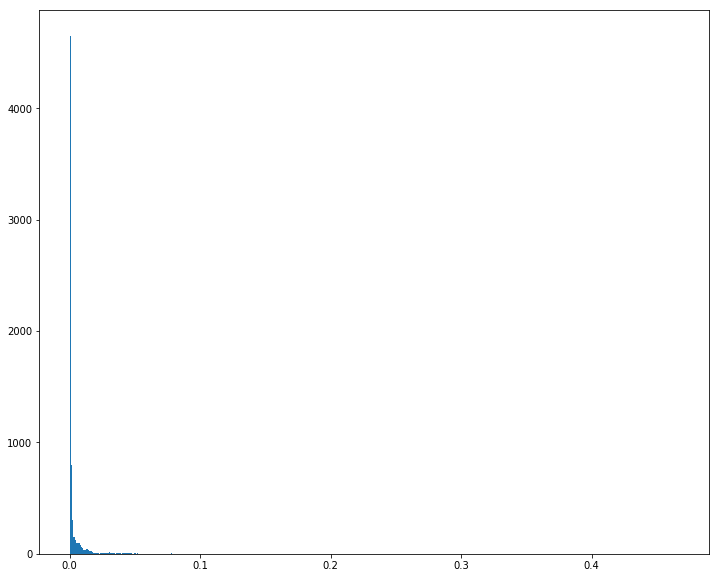

redteam_event        6991
dns_count            6991
newresolved_count    6991
fail_count           6991
LoggedOn             6991
dur                  6991
pkt_cnt              6991
byte_cnt             6991
avg_pkt_size         6991
proc_total           6991
proc_exec_total      6991
newexecute_count     6991
Proc_run             6991
dtype: int64

In [13]:
# Examine New Resoloved Count Run feature
newresolved_remove_noise = resampled_df[(resampled_df[['newresolved_count']] !=0).all(axis=1)]
newresolved_remove_pct = 1-(newresolved_remove_noise['newresolved_count'].count()/resampled_df['newresolved_count'].count())
print("We removed {0:2.8f}% of newresolved_count=0 observations to see outliers".format(newresolved_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(newresolved_remove_noise['newresolved_count'])
plt.figure(figsize=(12,10))
plt.hist(newresolved_remove_noise['newresolved_count'],bins=int(500))
plt.show()
newresolved_remove_noise.count()

We removed 0.00000000% of fail_count=0 observations to see outliers


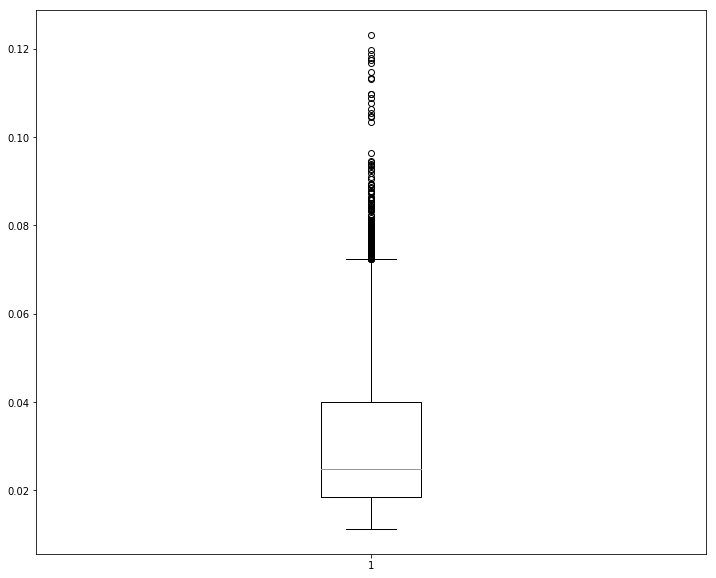

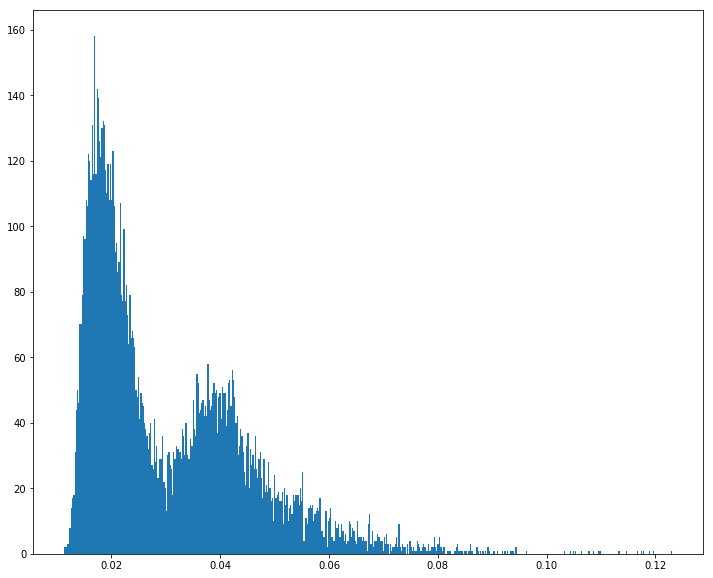

redteam_event        10081
dns_count            10081
newresolved_count    10081
fail_count           10081
LoggedOn             10081
dur                  10081
pkt_cnt              10081
byte_cnt             10081
avg_pkt_size         10081
proc_total           10081
proc_exec_total      10081
newexecute_count     10081
Proc_run             10081
dtype: int64

In [14]:
# Examine fail_count feature
failCnt_remove_noise = resampled_df[(resampled_df[['fail_count']] !=0).all(axis=1)]
failCnt_remove_pct = 1-(failCnt_remove_noise['fail_count'].count()/resampled_df['fail_count'].count())
print("We removed {0:2.8f}% of fail_count=0 observations to see outliers".format(failCnt_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(failCnt_remove_noise['fail_count'])
plt.figure(figsize=(12,10))
plt.hist(failCnt_remove_noise['fail_count'],bins=int(500))
plt.show()
failCnt_remove_noise.count()

We removed 0.00000000% of LoggedOn=0 observations to see outliers


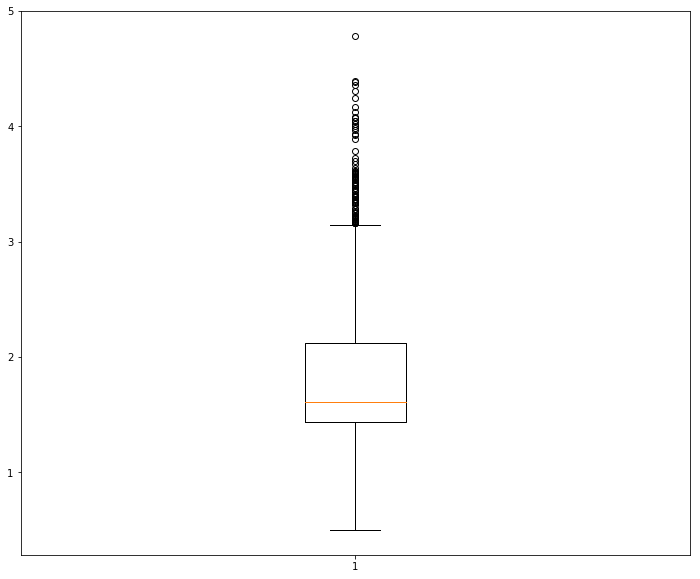

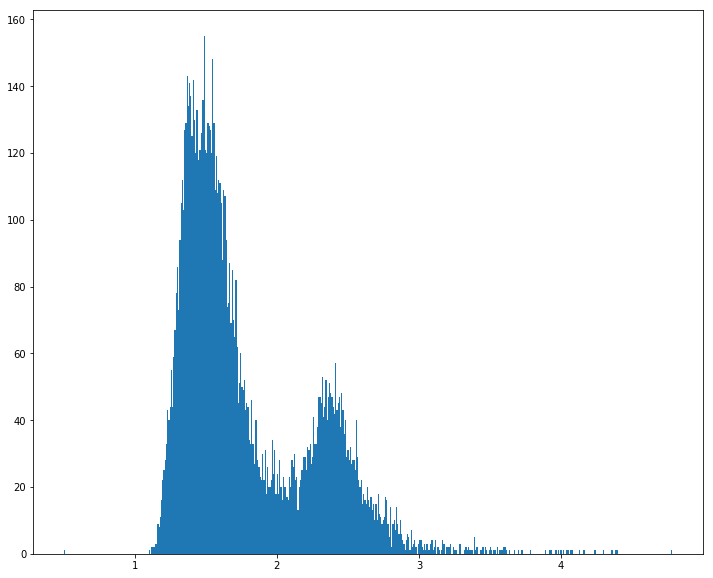

In [15]:
# Examine LoggedOn feature
LoggedOn_remove_noise = resampled_df[(resampled_df[['LoggedOn']] !=0).all(axis=1)]
LoggedOn_remove_pct = 1-(LoggedOn_remove_noise['LoggedOn'].count()/resampled_df['LoggedOn'].count())
LoggedOn_mean = resampled_df['LoggedOn'].mean
LoggedOn_std = resampled_df['LoggedOn'].std
#LoggedOnOutlier['Outlier'] = np.where(abs(resampled_df['LoggedOn'] - LoggedOn_mean) > 5 * LoggedOn_std,1,0)
    
print("We removed {0:2.8f}% of LoggedOn=0 observations to see outliers".format(LoggedOn_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(LoggedOn_remove_noise['LoggedOn'])
plt.figure(figsize=(12,10))
plt.hist(LoggedOn_remove_noise['LoggedOn'],bins=int(500))
plt.show()
#LoggedOnOutlier

We removed 25.47366333% of dur=0 observations to see outliers


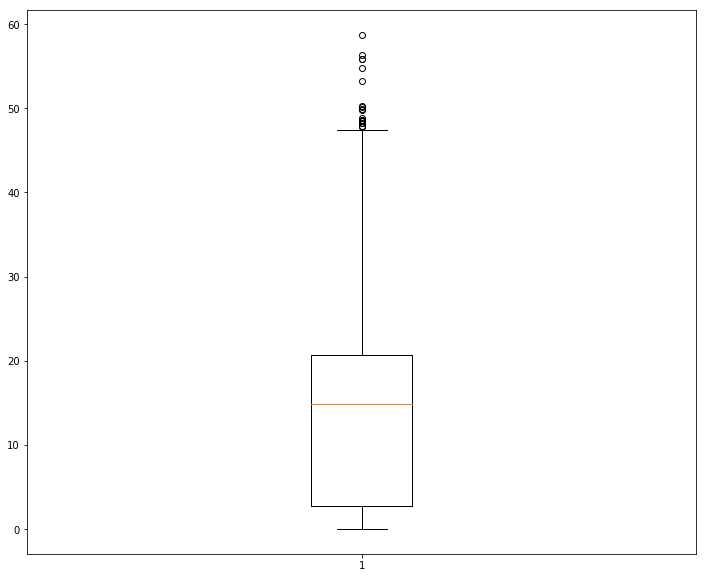

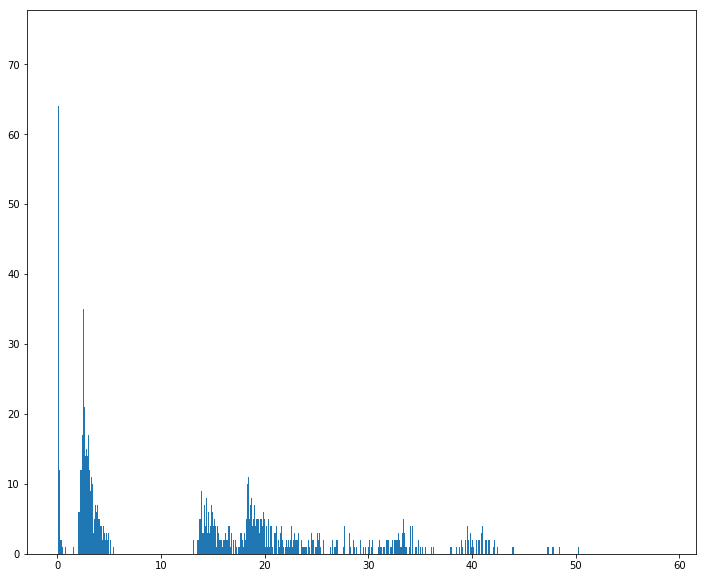

redteam_event        7513
dns_count            7513
newresolved_count    7513
fail_count           7513
LoggedOn             7513
dur                  7513
pkt_cnt              7513
byte_cnt             7513
avg_pkt_size         7513
proc_total           7513
proc_exec_total      7513
newexecute_count     7513
Proc_run             7513
dtype: int64

In [16]:
dur_remove_noise = resampled_df[(resampled_df[['dur']] !=0).all(axis=1)]
dur_remove_pct = 1-(dur_remove_noise['dur'].count()/resampled_df['dur'].count())
print("We removed {0:2.8f}% of dur=0 observations to see outliers".format(dur_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(dur_remove_noise['dur'])
plt.figure(figsize=(12,10))
plt.hist(dur_remove_noise['dur'],bins=int(5000))
plt.show()
dur_remove_noise.count()

We removed 25.45382403% of pkt_cnt=0 observations to see outliers


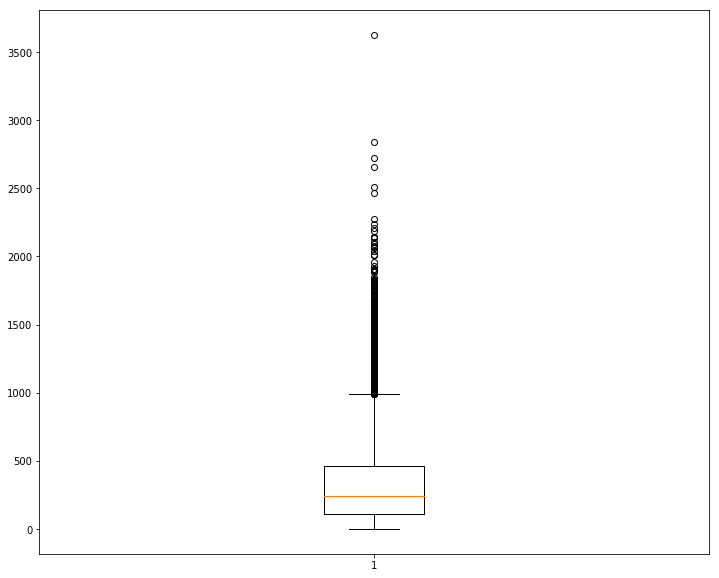

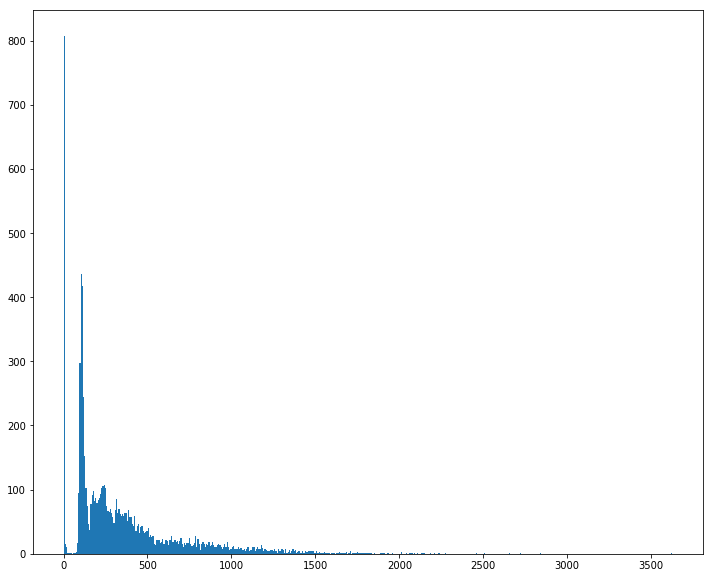

redteam_event        7515
dns_count            7515
newresolved_count    7515
fail_count           7515
LoggedOn             7515
dur                  7515
pkt_cnt              7515
byte_cnt             7515
avg_pkt_size         7515
proc_total           7515
proc_exec_total      7515
newexecute_count     7515
Proc_run             7515
dtype: int64

In [17]:
# Examine pkt_cnt feature
pkt_remove_noise = resampled_df[(resampled_df[['pkt_cnt']] !=0).all(axis=1)]
pkt_remove_pct = 1-(pkt_remove_noise['pkt_cnt'].count()/resampled_df['pkt_cnt'].count())
print("We removed {0:2.8f}% of pkt_cnt=0 observations to see outliers".format(pkt_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(pkt_remove_noise['pkt_cnt'])
plt.figure(figsize=(12,10))
plt.hist(pkt_remove_noise['pkt_cnt'],bins=int(500))
plt.show()
pkt_remove_noise.count()

We removed 25.45382403% of byte_cnt=0 observations to see outliers


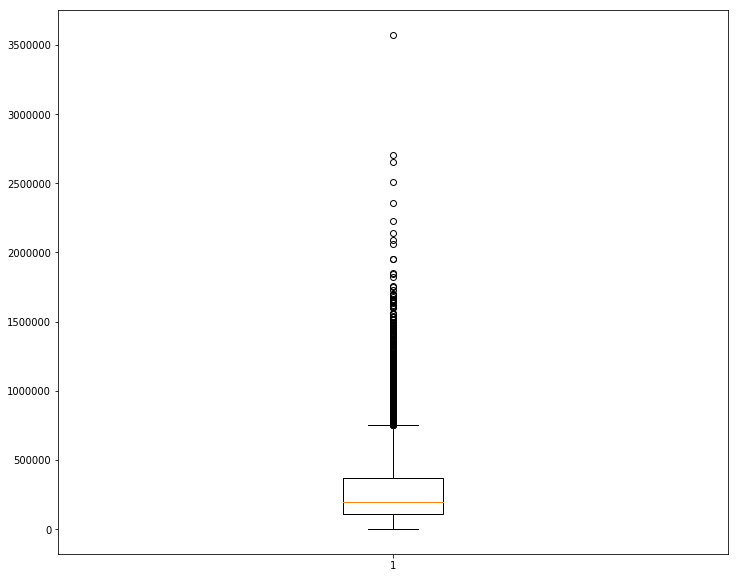

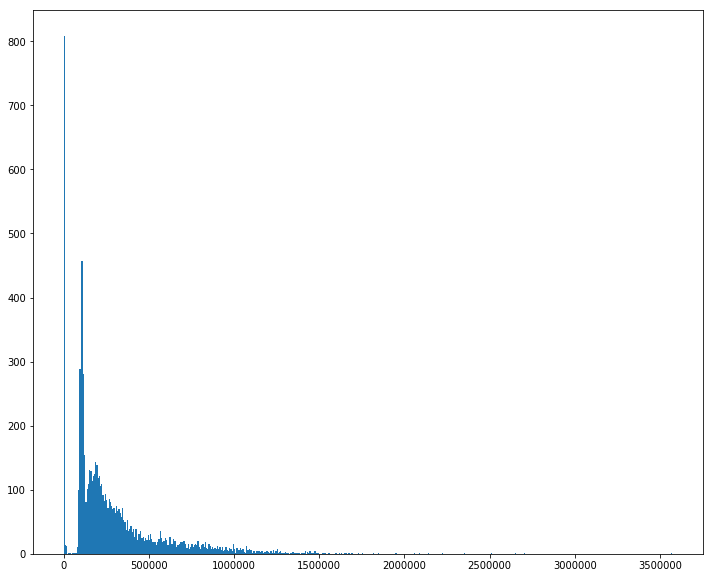

redteam_event        7515
dns_count            7515
newresolved_count    7515
fail_count           7515
LoggedOn             7515
dur                  7515
pkt_cnt              7515
byte_cnt             7515
avg_pkt_size         7515
proc_total           7515
proc_exec_total      7515
newexecute_count     7515
Proc_run             7515
dtype: int64

In [18]:
# Examine byte_cnt feature
byte_remove_noise = resampled_df[(resampled_df[['byte_cnt']] !=0).all(axis=1)]
byte_remove_pct = 1-(byte_remove_noise['byte_cnt'].count()/resampled_df['byte_cnt'].count())
print("We removed {0:2.8f}% of byte_cnt=0 observations to see outliers".format(byte_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(byte_remove_noise['byte_cnt'])
plt.figure(figsize=(12,10))
plt.hist(byte_remove_noise['byte_cnt'],bins=int(500))
plt.show()
byte_remove_noise.count()

We removed 25.45382403% of avg_pkt_size=0 observations to see outliers


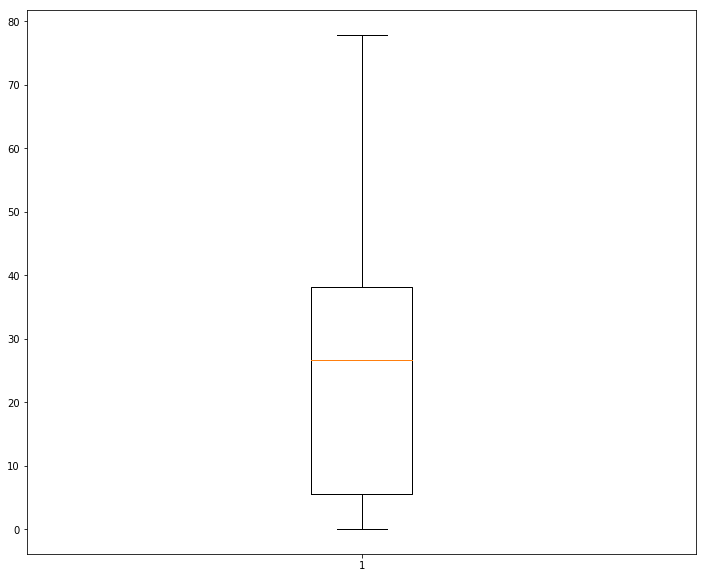

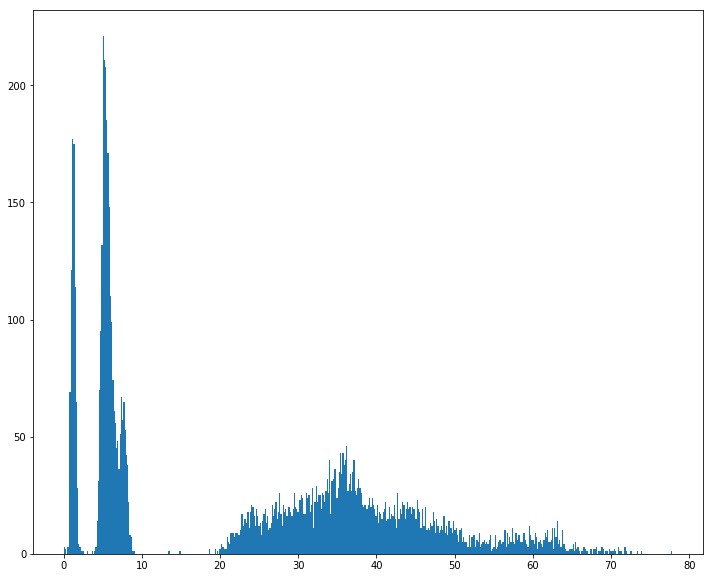

redteam_event        7515
dns_count            7515
newresolved_count    7515
fail_count           7515
LoggedOn             7515
dur                  7515
pkt_cnt              7515
byte_cnt             7515
avg_pkt_size         7515
proc_total           7515
proc_exec_total      7515
newexecute_count     7515
Proc_run             7515
dtype: int64

In [19]:
# Examine avg_pkt_aize feature
avgpkt_remove_noise = resampled_df[(resampled_df[['avg_pkt_size']] !=0).all(axis=1)]
avgpkt_remove_pct = 1-(avgpkt_remove_noise['avg_pkt_size'].count()/resampled_df['avg_pkt_size'].count())
print("We removed {0:2.8f}% of avg_pkt_size=0 observations to see outliers".format(avgpkt_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(avgpkt_remove_noise['avg_pkt_size'])
plt.figure(figsize=(12,10))
plt.hist(avgpkt_remove_noise['avg_pkt_size'],bins=int(500))
plt.show()
avgpkt_remove_noise.count()

We removed 0.00000000% of proc_total=0 observations to see outliers


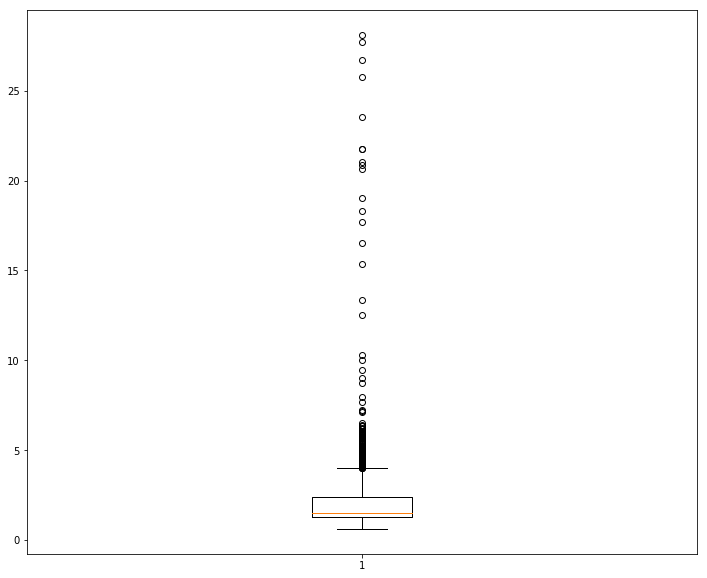

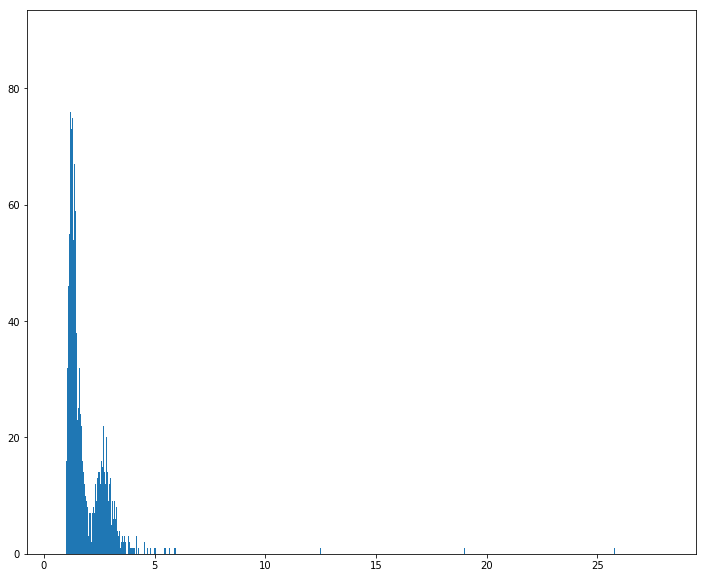

redteam_event        10081
dns_count            10081
newresolved_count    10081
fail_count           10081
LoggedOn             10081
dur                  10081
pkt_cnt              10081
byte_cnt             10081
avg_pkt_size         10081
proc_total           10081
proc_exec_total      10081
newexecute_count     10081
Proc_run             10081
dtype: int64

In [20]:
# Examine proc_total feature
proc_remove_noise = resampled_df[(resampled_df[['proc_total']] !=0).all(axis=1)]
proc_remove_pct = 1-(proc_remove_noise['proc_total'].count()/resampled_df['proc_total'].count())
print("We removed {0:2.8f}% of proc_total=0 observations to see outliers".format(proc_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(proc_remove_noise['proc_total'])
plt.figure(figsize=(12,10))
plt.hist(proc_remove_noise['proc_total'],bins=int(5000))
plt.show()
proc_remove_noise.count()

We removed 0.00000000% of proc_exec_total=0 observations to see outliers


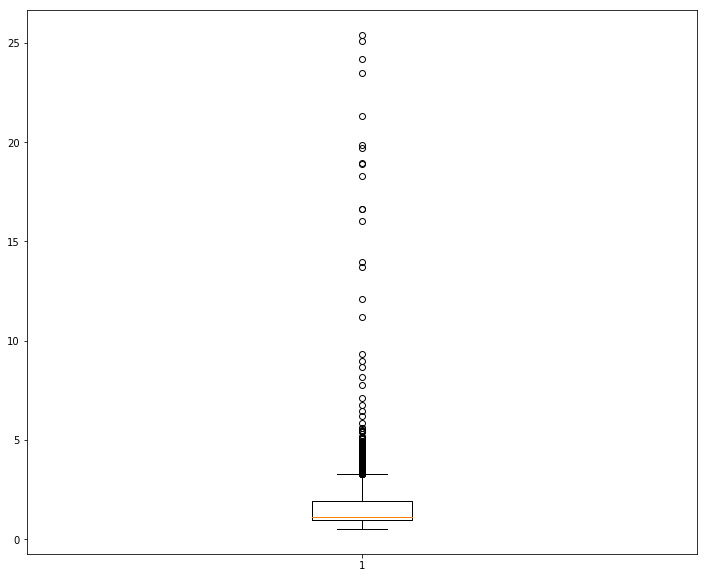

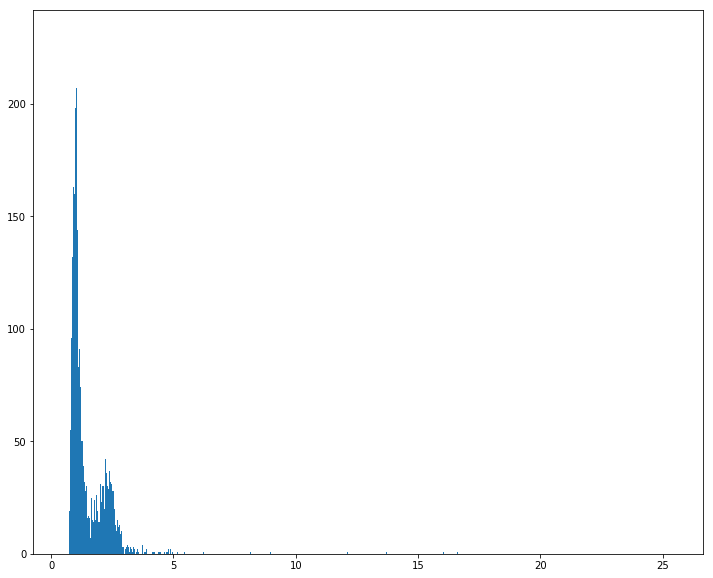

redteam_event        10081
dns_count            10081
newresolved_count    10081
fail_count           10081
LoggedOn             10081
dur                  10081
pkt_cnt              10081
byte_cnt             10081
avg_pkt_size         10081
proc_total           10081
proc_exec_total      10081
newexecute_count     10081
Proc_run             10081
dtype: int64

In [21]:
# Examine proc_exec_total feature
proce_remove_noise = resampled_df[(resampled_df[['proc_exec_total']] !=0).all(axis=1)]
proce_remove_pct = 1-(proce_remove_noise['proc_exec_total'].count()/resampled_df['proc_exec_total'].count())
print("We removed {0:2.8f}% of proc_exec_total=0 observations to see outliers".format(proce_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(proce_remove_noise['proc_exec_total'])
plt.figure(figsize=(12,10))
plt.hist(proce_remove_noise['proc_exec_total'],bins=int(2500))
plt.show()
proce_remove_noise.count()

We removed 11.02073207% of newexecute_count=0 observations to see outliers


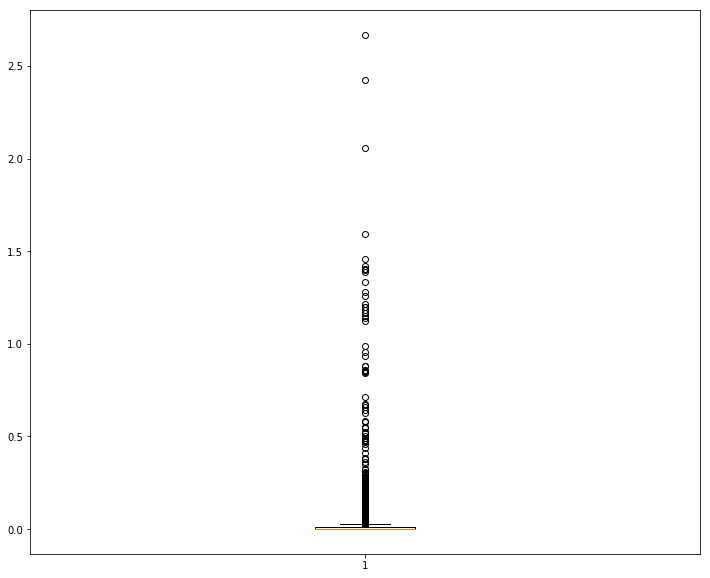

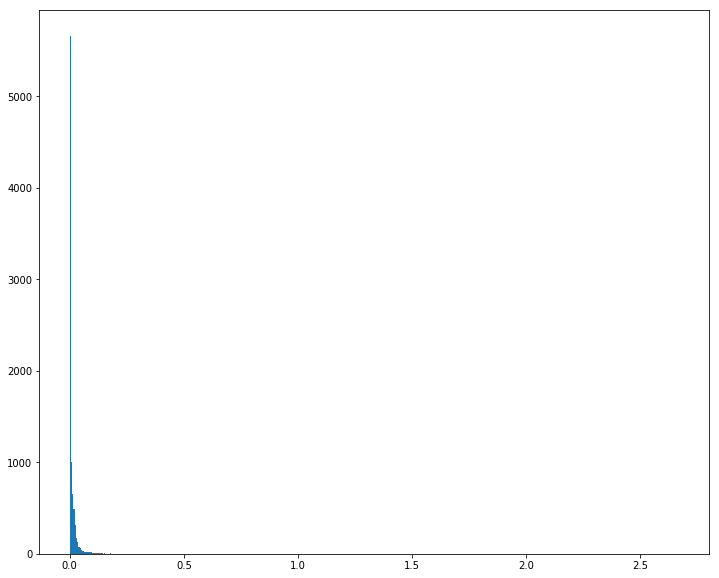

redteam_event        8970
dns_count            8970
newresolved_count    8970
fail_count           8970
LoggedOn             8970
dur                  8970
pkt_cnt              8970
byte_cnt             8970
avg_pkt_size         8970
proc_total           8970
proc_exec_total      8970
newexecute_count     8970
Proc_run             8970
dtype: int64

In [22]:
# Examine newexecute_count
newexe_remove_noise = resampled_df[(resampled_df[['newexecute_count']] !=0).all(axis=1)]
newexe_remove_pct = 1-(newexe_remove_noise['newexecute_count'].count()/resampled_df['newexecute_count'].count())
print("We removed {0:2.8f}% of newexecute_count=0 observations to see outliers".format(newexe_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(newexe_remove_noise['newexecute_count'])
plt.figure(figsize=(12,10))
plt.hist(newexe_remove_noise['newexecute_count'],bins=int(500))
plt.show()
newexe_remove_noise.count()

We removed 0.00000000% of Proc_run=0 observations to see outliers


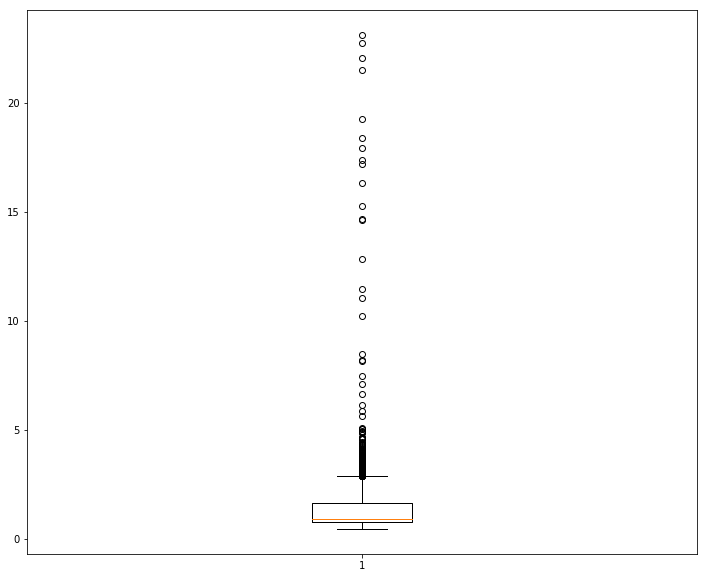

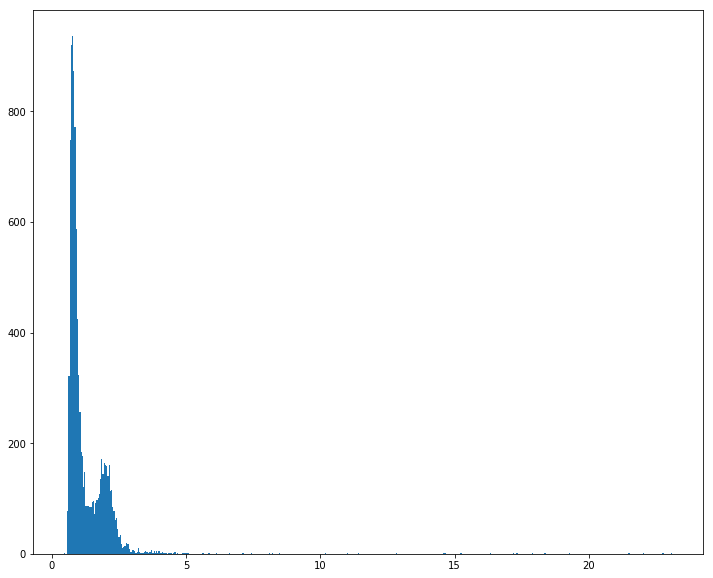

redteam_event        10081
dns_count            10081
newresolved_count    10081
fail_count           10081
LoggedOn             10081
dur                  10081
pkt_cnt              10081
byte_cnt             10081
avg_pkt_size         10081
proc_total           10081
proc_exec_total      10081
newexecute_count     10081
Proc_run             10081
dtype: int64

In [23]:
# Examine Proc Run
procr_remove_noise = resampled_df[(resampled_df[['Proc_run']] !=0).all(axis=1)]
procr_remove_pct = 1-(procr_remove_noise['Proc_run'].count()/resampled_df['Proc_run'].count())
print("We removed {0:2.8f}% of Proc_run=0 observations to see outliers".format(procr_remove_pct*100))
plt.figure(figsize=(12,10))
plt.boxplot(procr_remove_noise['Proc_run'])
plt.figure(figsize=(12,10))
#sns.distplot(procr_remove_noise, fit=norm, kde=False)
plt.hist(procr_remove_noise['Proc_run'],bins=int(500))
plt.show()
procr_remove_noise.count()

In [24]:
%matplotlib inline

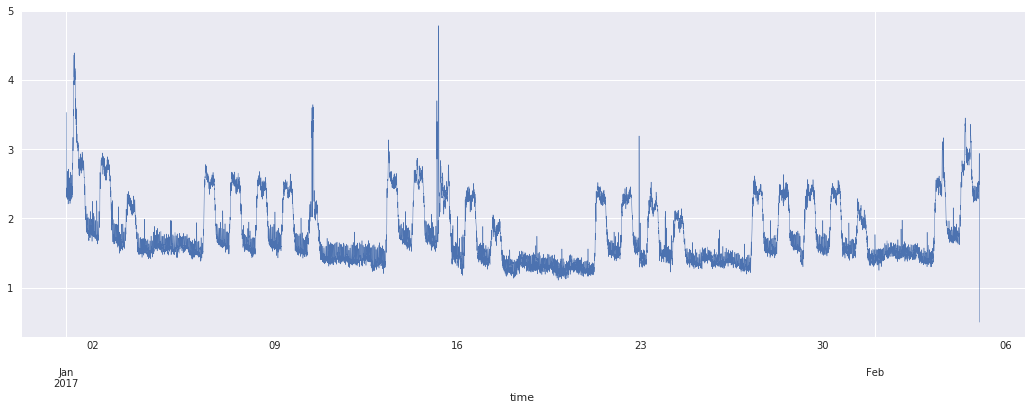

In [25]:
# Test plot to add styles and features
sns.set(rc={'figure.figsize':(18,6)})
resampled_df['LoggedOn'].plot(linewidth=0.5);


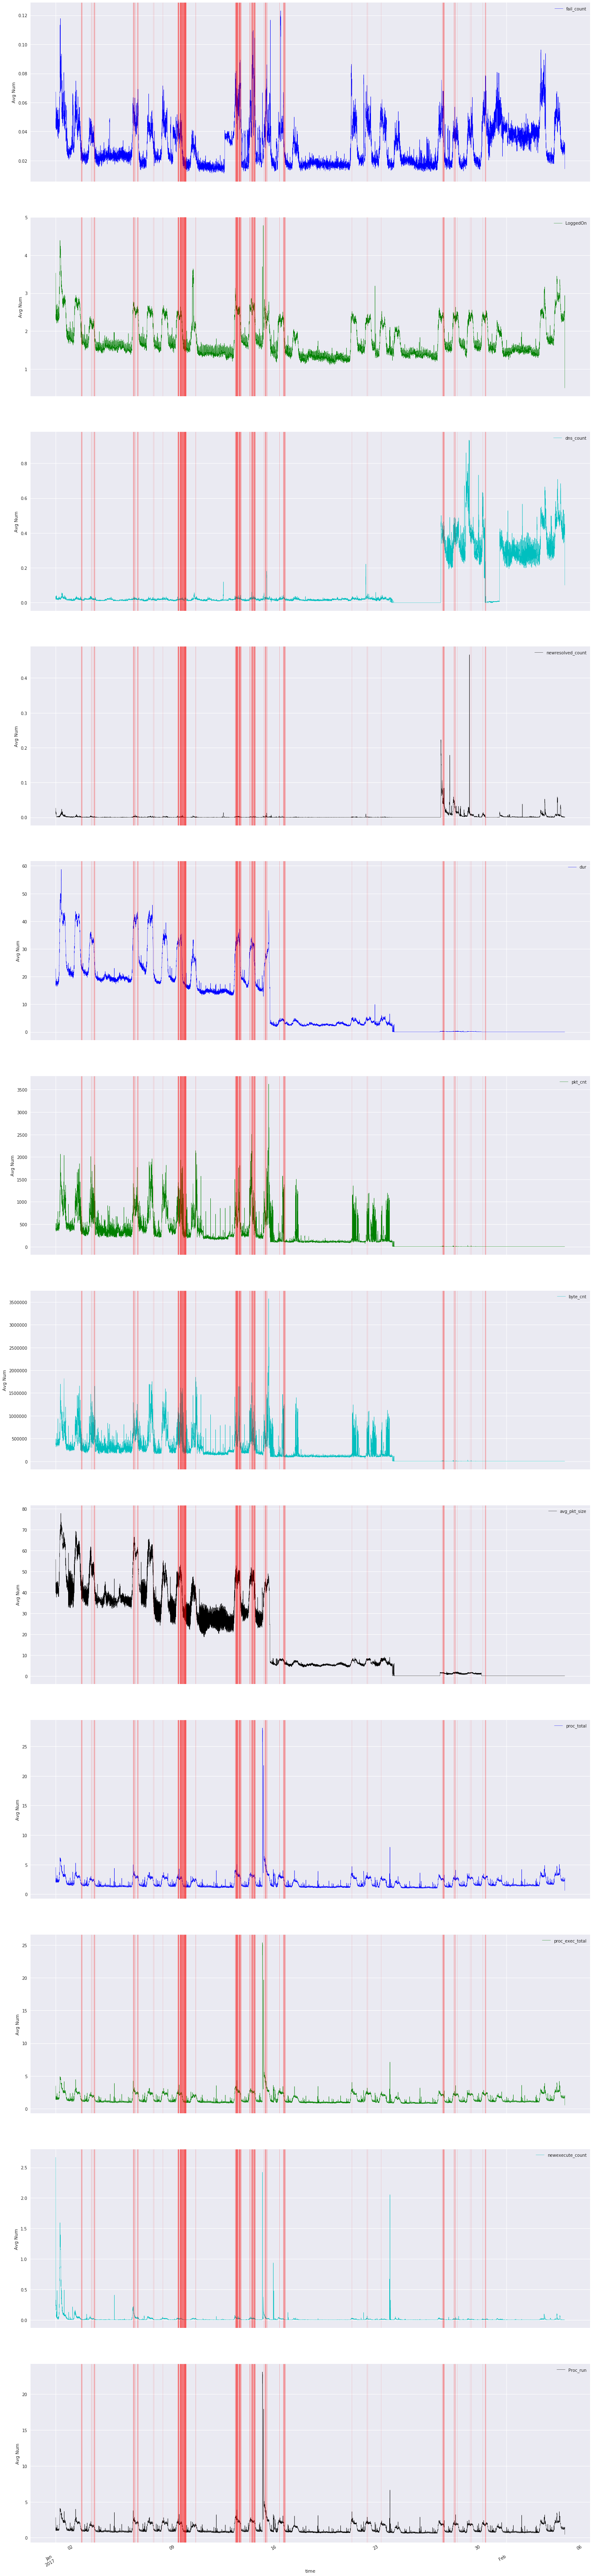

In [31]:
cols_plot =['fail_count','LoggedOn','dns_count','newresolved_count','dur','pkt_cnt','byte_cnt',
            'avg_pkt_size','proc_total','proc_exec_total','newexecute_count','Proc_run']

colors =['b','g','c','k','b','g','c','k','b','g','c','k']
axes = resampled_df[cols_plot].plot(figsize=(24, 124), linewidth=0.5, linestyle='-',subplots=True, color=colors)

for ax in axes:
    ax.set_ylabel('Avg Num') 
    for dates in redteam_events:
        ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)

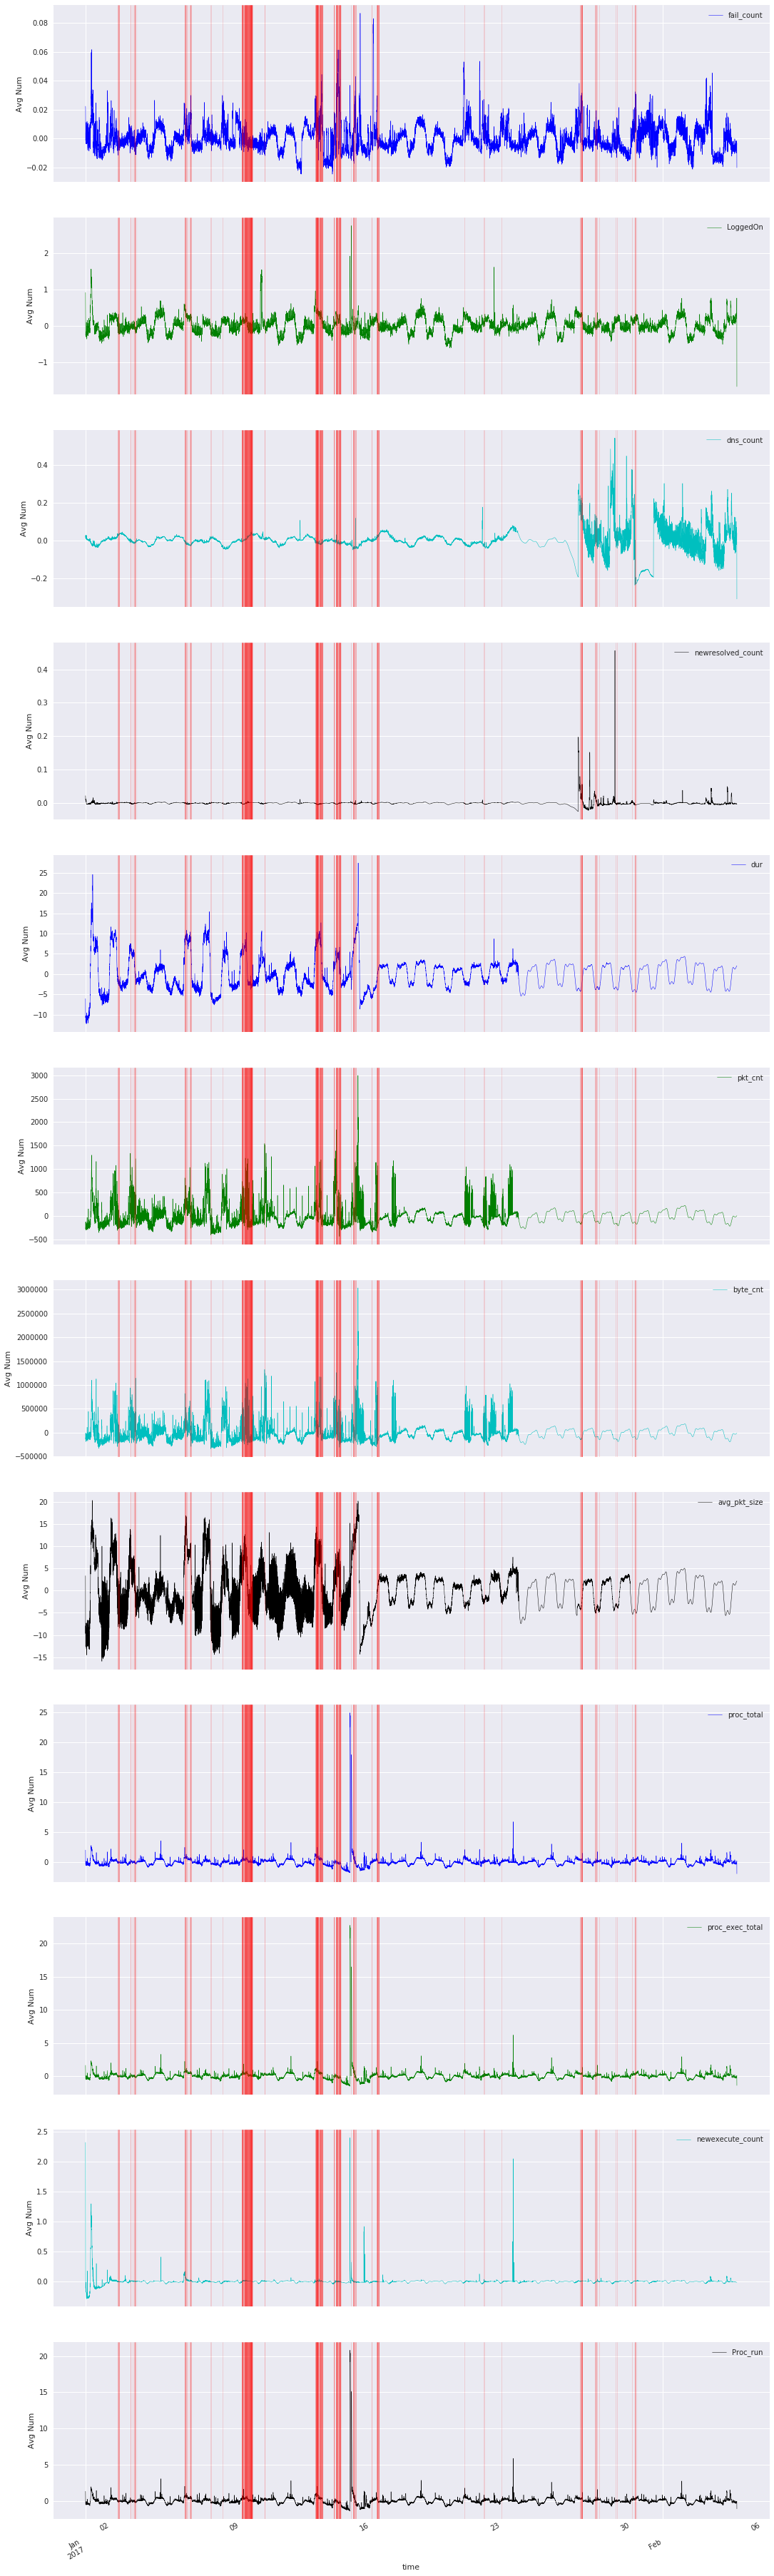

In [27]:

cols_plot =['fail_count','LoggedOn','dns_count','newresolved_count','dur','pkt_cnt','byte_cnt',
            'avg_pkt_size','proc_total','proc_exec_total','newexecute_count','Proc_run']

colors =['b','g','c','k','b','g','c','k','b','g','c','k']
axes = normalized_df[cols_plot].plot(figsize=(18, 72), linewidth=0.5, linestyle='-',subplots=True, color=colors)

for ax in axes:
    ax.set_ylabel('Avg Num') 
    for dates in redteam_events:
        ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)

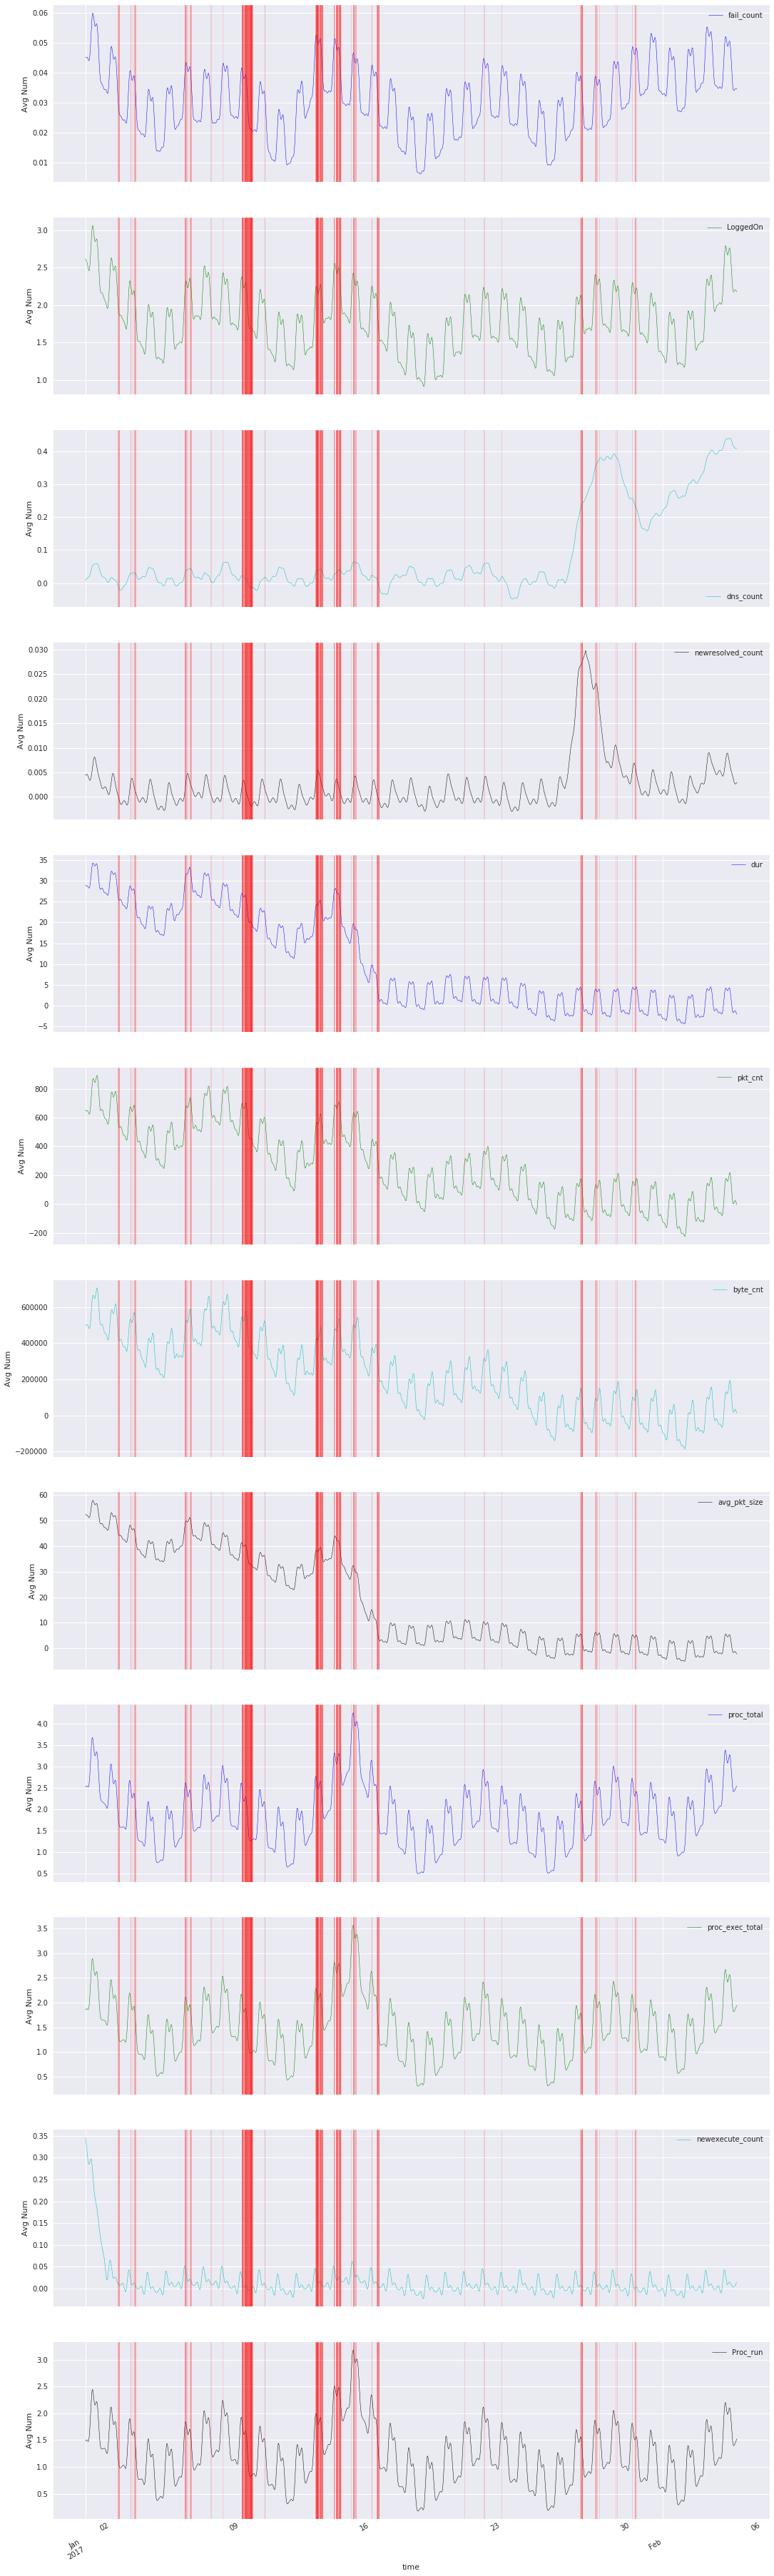

In [28]:

cols_plot =['fail_count','LoggedOn','dns_count','newresolved_count','dur','pkt_cnt','byte_cnt',
            'avg_pkt_size','proc_total','proc_exec_total','newexecute_count','Proc_run']

colors =['b','g','c','k','b','g','c','k','b','g','c','k']
axes = timeseries_df[cols_plot].plot(figsize=(18, 72), linewidth=0.5, linestyle='-',subplots=True, color=colors)

for ax in axes:
    ax.set_ylabel('Avg Num') 
    for dates in redteam_events:
        ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)

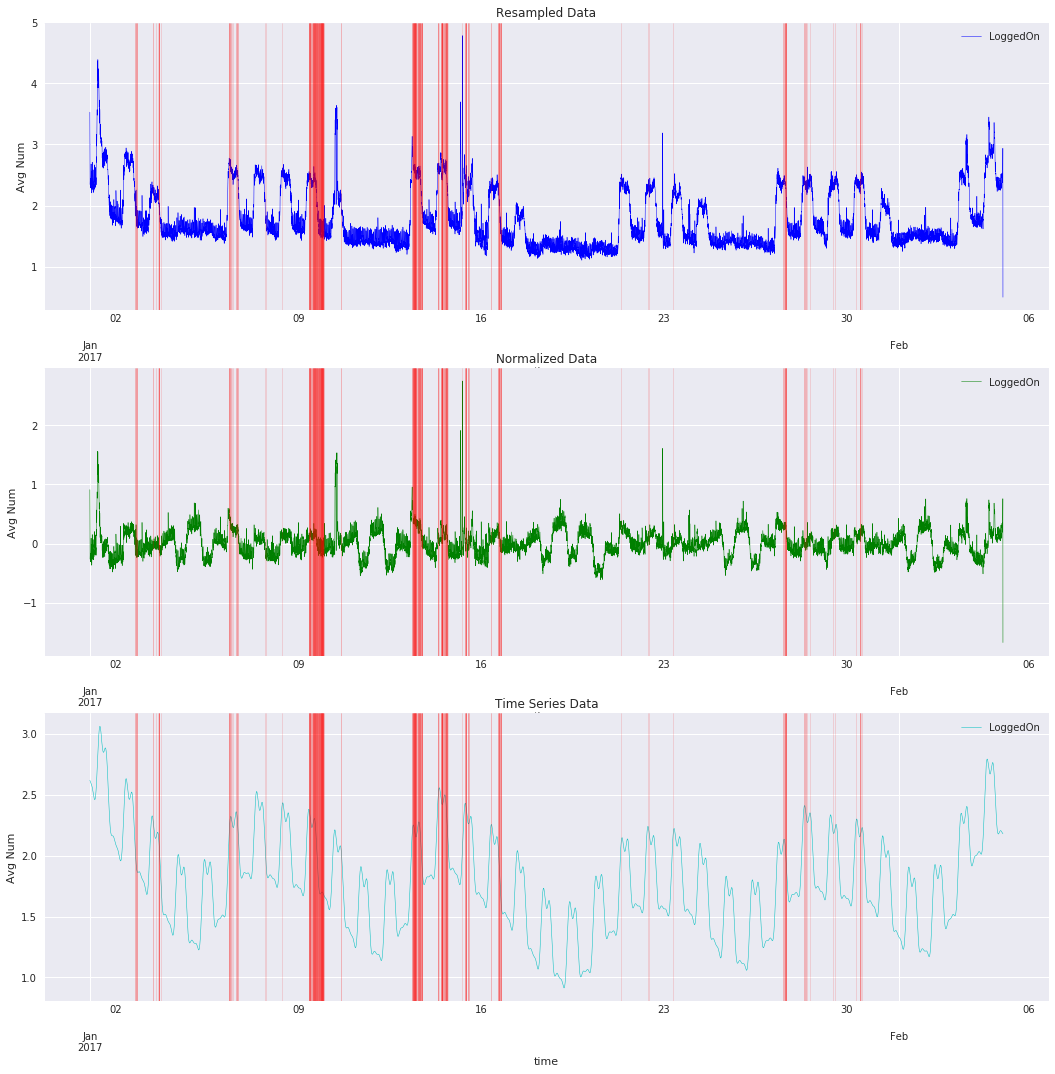

In [55]:
#
# Make 3 graphs with of the LoggedOn feature but use resampled, timeseries, normalized to compare against each other
#
dataToPlot =[resampled_df,normalized_df,timeseries_df]
plotTitles =['Resampled Data', 'Normalized Data', 'Time Series Data']
colors = ['b','g','c']
sns.set(rc={'figure.figsize':(18,18)})
for i in range (0,len(dataToPlot)):
    plt.subplot(3,1,i+1)
    axes = dataToPlot[i]['LoggedOn'].plot(figsize=(18, 72), linewidth=0.5, linestyle='-',subplots=True, color=colors[i])
    for ax in axes:
        ax.set_ylabel('Avg Num') 
        plt.legend(loc='best')
        ax.set_title(plotTitles[i])
        for dates in redteam_events:
            ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)
plt.savefig('LoggedOn')

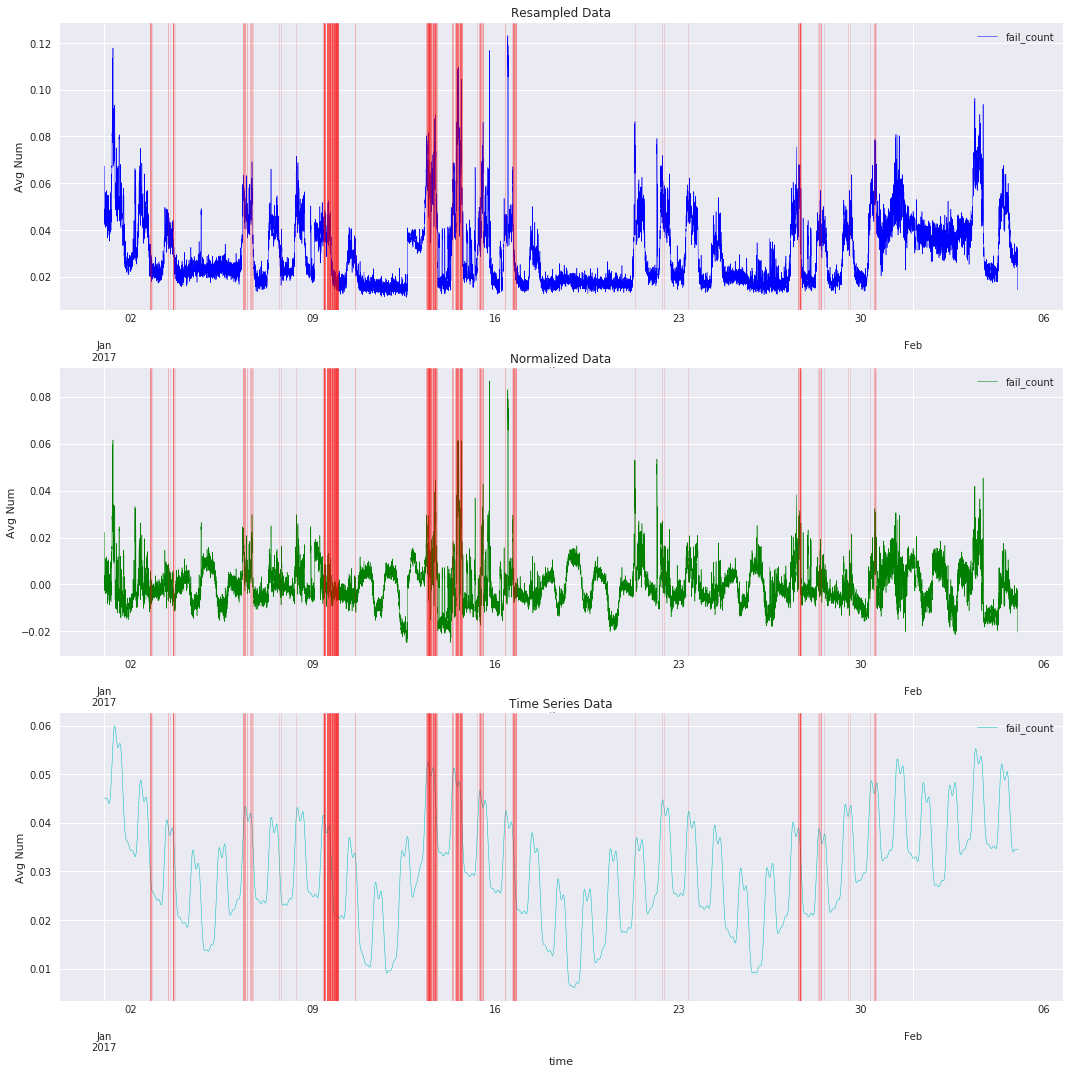

In [56]:
#
# Make 3 graphs with of the LoggedOn feature but use resampled, timeseries, normalized to compare against each other
#
dataToPlot =[resampled_df,normalized_df,timeseries_df]
plotTitles =['Resampled Data', 'Normalized Data', 'Time Series Data']
colors = ['b','g','c']
sns.set(rc={'figure.figsize':(18,18)})
for i in range (0,len(dataToPlot)):
    plt.subplot(3,1,i+1)
    axes = dataToPlot[i]['fail_count'].plot(figsize=(18, 72), linewidth=0.5, linestyle='-',subplots=True, color=colors[i])
    for ax in axes:
        ax.set_ylabel('Avg Num') 
        plt.legend(loc='best')
        ax.set_title(plotTitles[i])
        for dates in redteam_events:
            ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)
plt.savefig('FailCount')

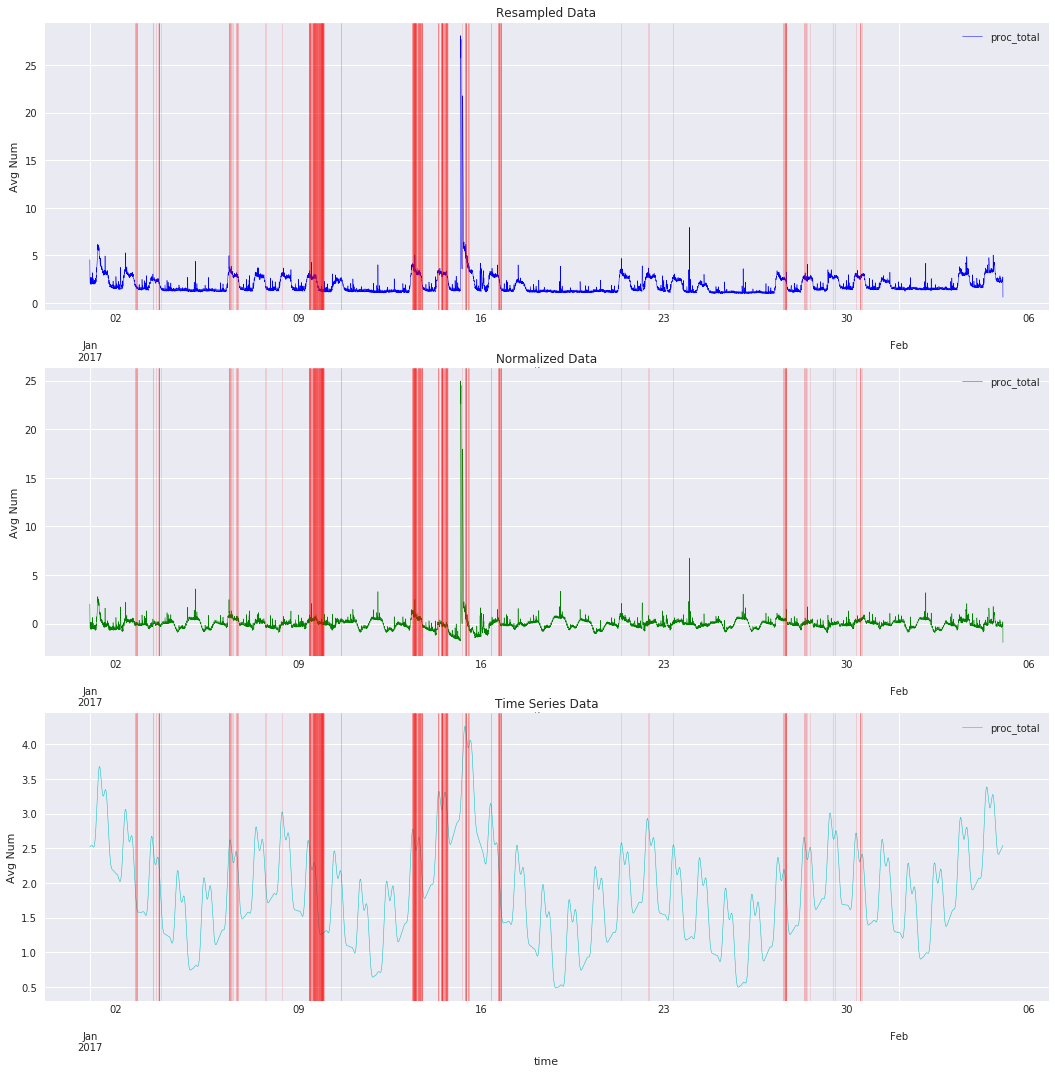

In [53]:
#
# Make 3 graphs with of the LoggedOn feature but use resampled, timeseries, normalized to compare against each other
#
dataToPlot =[resampled_df,normalized_df,timeseries_df]
plotTitles =['Resampled Data', 'Normalized Data', 'Time Series Data']
colors = ['b','g','c']
sns.set(rc={'figure.figsize':(18,18)})
for i in range (0,len(dataToPlot)):
    plt.subplot(3,1,i+1)
    axes = dataToPlot[i]['proc_total'].plot(figsize=(18, 72), linewidth=0.5, linestyle='-',subplots=True, color=colors[i])
    for ax in axes:
        ax.set_ylabel('Avg Num') 
        plt.legend(loc='best')
        ax.set_title(plotTitles[i])
        for dates in redteam_events:
            ax.axvline(x=dates, ymin=0, ymax=1,linewidth=0.5, color='r',alpha=.25)
plt.savefig('ProcTotal')